# Estimating reaction model parameter uncertainty with Markov Chain Monte Carlo, Redux
In 2013, I published [Estimating reaction model parameter uncertainty with Markov Chain Monte Carlo](http://dx.doi.org/10.1016/j.compchemeng.2012.07.011) At the time, the best available open source technology to perform Bayesian inference around ODEs was a program callled PKBugs, that used a janky Euler solver and had other limitations.  [Stan](https://mc-stan.org) and [Julia](https://julialang.org) were only just getting started and were off of my radar. So, I opted to write my own homebrew adaptive M-H sampler in Matlab to solve ODEs and infer their parameters from simulated experimental data.  To my shame, the code was not inlcuded with the publication as in addition to being extremely inefficient (many hours to do 100k samples with 5% efficiency or less) it was not written to benefit others and could not clearly convey the methodology.  Nearly a decade later, I hope to atone for this by sharing the implementation in Julia.  This notebook will not follow the outline of the paper, but will generate similar figures to the paper. 

Load libraries:

In [1]:
cd(@__DIR__)
using Pkg; Pkg.activate("."); Pkg.instantiate()

using DiffEqBase
using OrdinaryDiffEq
using DifferentialEquations
using DataDrivenDiffEq
using BenchmarkTools
using DiffEqBayes, Turing
using Plots,StatsPlots, StatsFuns, StatsBase
using Random
using StaticArrays, LinearAlgebra  #Distributions.jl is not compatible with StaticArrays currently
using MAT
Turing.setadbackend(:forwarddiff)
gr()

 Activating environment at `~/Dropbox/julia/universal_differential_equations/ChemicalKinetics/Project.toml`


Plots.GRBackend()

In [2]:
import Logging
Logging.disable_logging(Logging.Warn); # disable mcmc warns

Specify groud truth model parameters.  For performance, consider using const for the global variables

In [3]:
R = 8.314/1000 # kJ/mol-K
T_ref = 293.15
Temps = [283.15, 293.15, 303.15]

θ₁ = 0.1
θ₂ = [0.1]
θ₃ = [0.48,0.09,75.0,80.0]
logθ₃ = log.(θ₃)
θ₄ = [65.4,365.0,5.4,0.881]


C₀₁ = 0.1  # A₀ = B₀ = 100mM
C₀₂ = [100e-3,150e-3,0]
C₀₃ = [186e-3,353e-3,0.0,0.0]
C₀₄ = [220e-3 660e-3 264e-3 0 0 0 0;
        220e-3 110e-3 264e-3 0 0 0 0;
        220e-3 660e-3 132e-3 0 0 0 0]  # Three sets of initial concentrations
cat₀ =  2.2e-3

model1(inv_c,θ₁,t) = θ₁*t.+inv_c  # linear model for second order kinetics

function model2(dc,c,p,t)
    dc[1] = -p[1]*c[1]*c[2]
    dc[2] = -p[1]*c[1]*c[2]
    dc[3] = p[1]*c[1]*c[2]
end

arr_rate(k::Real,Ea::Real,T::Real) = k*exp(-Ea/R*((1.0/T)-(1.0/T_ref)))

function model3(dc,c,θ₃T,t)
    dc[1] = -arr_rate(θ₃T[1],θ₃T[3],θ₃T[5])*c[1]*c[2]
    dc[4] = arr_rate(θ₃T[2],θ₃T[4],θ₃T[5])*c[3]*c[2]
    dc[2] =  -arr_rate(θ₃T[1],θ₃T[3],θ₃T[5])*c[1]*c[2]-arr_rate(θ₃T[2],θ₃T[4],θ₃T[5])*c[3]*c[2]
    dc[3] = arr_rate(θ₃T[1],θ₃T[3],θ₃T[5])*c[1]*c[2]-arr_rate(θ₃T[2],θ₃T[4],θ₃T[5])*c[3]*c[2]
end

function model4(dc,c,θ₄,t)
    cat = max(1e-10,cat₀ - c[5] - c[6] - c[7])
    dc[1] = -θ₄[1]*c[1]*cat  #A
    dc[2] = -θ₄[2]*c[2]*c[5] # B
    dc[3] = -θ₄[3]*c[3]*c[6] #C
    dc[4] = θ₄[4]*c[7] #D
    dc[5] = dc[2] - dc[1] #Acat
    dc[6] = dc[3] - dc[2] #ABcat
    dc[7] = -dc[3] - dc[4] #Dcat
end
;

Because model 3 and model 4 are are rerun for different conditions, wrap a function around these models.  Specifiy the data type to hopefully get more speed, but `ForwardDiff` needs it to be no less generic than `Real`

In [4]:
function model3set(θ₃::Array{<:Real,1},timepoints::Array{<:Real,1})
    Y  = []
    for ix in 1:length(Temps)
        prob3 = ODEProblem(model3, C₀₃, (0.0,maximum(timepoints)), [θ₃...,Temps[ix]])
        solution3 = solve(prob3, saveat = timepoints, verbose = false,save_idxs=[3,4],save_everystep=false)
        push!(Y,hcat(solution3.u...))
    end 
    return Y
end

function model4set(θ₄::Array{<:Real,1},timepoints::Array{<:Real,1})
    Y  =  []
    for ix in 1:size(C₀₄,1)
        prob4 = ODEProblem(model4, C₀₄[ix,:], (0.0,maximum(timepoints)), θ₄)
        solution4 = solve(prob4, saveat = timepoints, verbose = false,save_idxs=[1],save_everystep=false)
        push!(Y, vcat(solution4.u...))
    end 
    return Y
end
;

Next use the models to generate some ground truth data, using a high density sampling resolution (HD) and sparse sampling (SD) time points, this compares to Fig 2 in the paper:

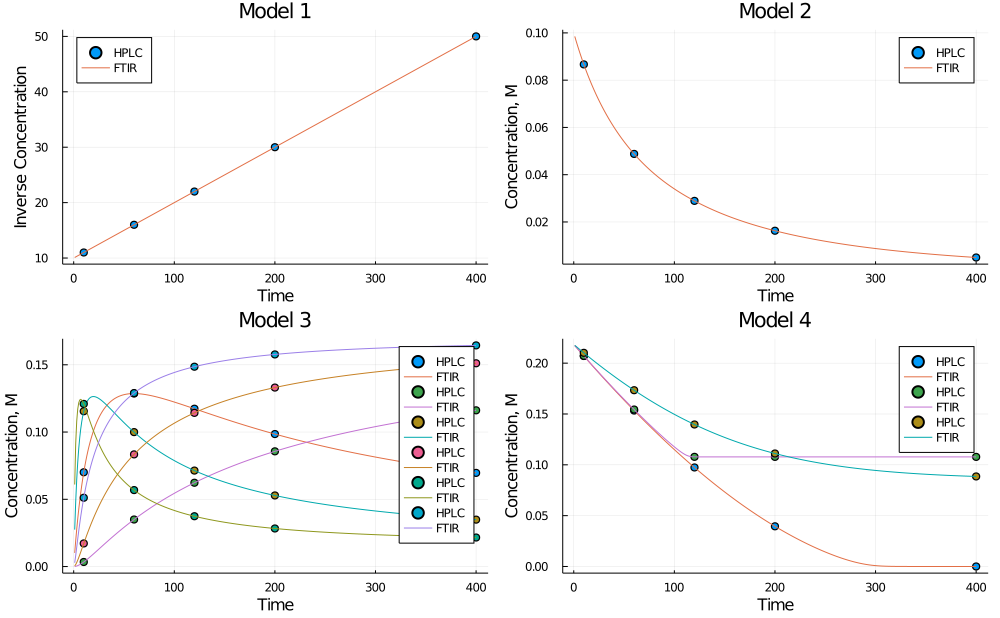

In [5]:
tspan_SD = Array{Float64,1}([10, 60, 120, 200, 400])
tspan_HD = Array{Float64,1}((1:400))

# Model 1
solution1_SD = model1(1 ./C₀₁,θ₁,tspan_SD)
solution1_HD = model1(1 ./C₀₁,θ₁,tspan_HD)
p1 = scatter(tspan_SD,solution1_SD,label="HPLC")
plot!(p1,tspan_HD,solution1_HD,label="FTIR",legend=:topleft)
xlabel!(p1,"Time")
ylabel!(p1,"Inverse Concentration")
title!("Model 1")

# Model 2
## generate some data
prob2_SD = ODEProblem(model2, C₀₂, (0.0,maximum(tspan_SD)), θ₂)
prob2_HD = ODEProblem(model2, C₀₂, (0.0,maximum(tspan_HD)), θ₂)

solution2_SD = solve(prob2_SD, saveat = tspan_SD, verbose = false,save_idxs= [1], save_everystep = false)
solution2_HD = solve(prob2_HD, saveat = tspan_HD, verbose = false,save_idxs = [1], save_everystep = false)

p2 = scatter(solution2_SD.t,vcat(solution2_SD.u...),label="HPLC")
plot!(p2,solution2_HD.t,vcat(solution2_HD.u...),label="FTIR")
ylabel!("Concentration, M")
xlabel!("Time")
title!("Model 2")

# Model 3
solution3_SD = model3set(θ₃,tspan_SD)
solution3_HD = model3set(θ₃,tspan_HD)

p3 = plot(title="Model 3")
for temp in 1:3
    for conc in 1:2
        scatter!(p3,tspan_SD,solution3_SD[temp][conc,:],label="HPLC")
        plot!(p3,tspan_HD,solution3_HD[temp][conc,:],label="FTIR")
    end
end
ylabel!("Concentration, M")
xlabel!("Time")
# Model 4
solution4_SD = model4set(θ₄,tspan_SD)
solution4_HD = model4set(θ₄,tspan_HD)

p4 = plot(title="Model 4")
for ICs in 1:3
        scatter!(p4,tspan_SD,solution4_SD[ICs],label="HPLC")
        plot!(p4,tspan_HD,solution4_HD[ICs],label="FTIR")
end
ylabel!("Concentration, M")
xlabel!("Time")

l = @layout [a b; c d]
plot(p1,p2,p3,p4, layout = l,size=(1000,618))

# Perform MCMC with Turing.jl
`DiffEqBayes.jl` is a promising package, but currently seems able to only work on single integration, not the larger data sets of Models 3 and 4. Use Turing.jl for coding up the MCMC models: 

## Model 1 Normal Error
Compare to Fig 10a in the paper

MCMC Model 1


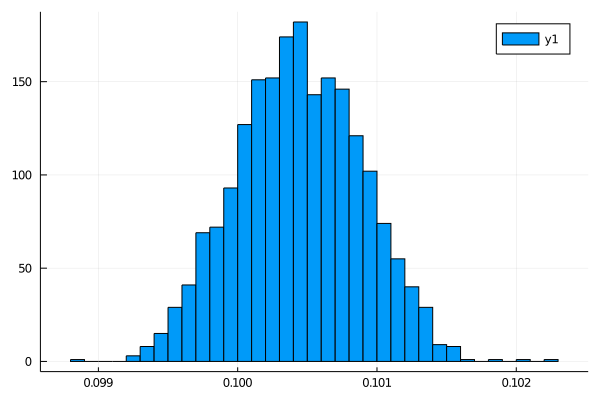

In [6]:
# try MCMC inference 

@model function fitm1(data,tspan)
    σ ~ InverseGamma(2, 0.1) # broad prior
    α ~ truncated(Normal(0.2,1),1e-5,1)
    predicted = model1(1 ./C₀₁,α,tspan)
    for i = 1:length(predicted)
        data[i] ~ Normal(1 /predicted[i], σ) #invert back to mM⁻¹
    end
    
end
println("MCMC Model 1")
X = 1 ./solution1_HD # invert to mM
ϵ= 0.08./2*mean(X)
Random.seed!(42) # set seed
Xₙ = X + ϵ*randn(eltype(X), size(X)) #add error
model = fitm1(Xₙ,tspan_HD) # 
chain = sample(model, NUTS(),MCMCThreads(), 1000, 4)
val = get(chain, [:lp,:α])
histogram(vec(val.α))

## Model 2 Normal Error
Compare to Fig 11a in the paper

MCMC Model 2


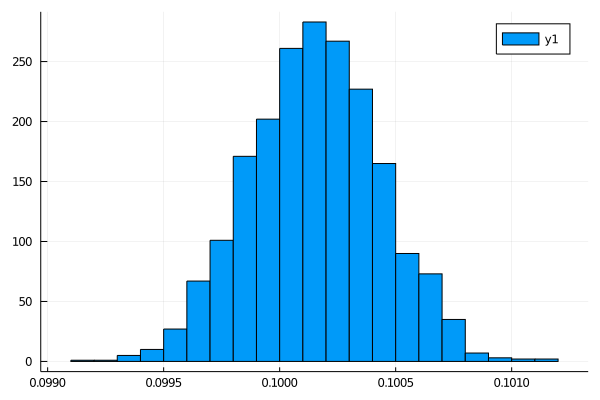

In [7]:
@model function fitm2(data,tspan)
    σ ~ InverseGamma(2, 0.1)
    α ~ truncated(Normal(0.2,1.0),1e-5,2)
    prob = ODEProblem(model2, C₀₂, (0.0,maximum(tspan)), [α])
    solution2 = solve(prob,Tsit5(), saveat = tspan,verbose = false,save_idxs= [1], save_everystep = false)
    predicted =vcat(solution2.u...)
    for i = 1:length(predicted)
        data[i] ~ Normal(predicted[i], σ)
    end
end
println("MCMC Model 2")
X = vcat(solution2_HD.u...)
ϵ= 0.08./2*mean(X)
Random.seed!(42) # set seed
Xₙ = X + (ϵ)*randn(eltype(X), size(X))
model = fitm2(Xₙ,tspan_HD) 
chain = sample(model, NUTS(),MCMCThreads(), 1000, 4)
val = get(chain, [:lp,:α])
histogram(vec(val.α))

## Model 3 Normal Error
Compare to Fig 12 in the paper

In [8]:

@model function fitm3(data,tspan)
    σ ~ InverseGamma(2, 0.1)
    α ~ truncated(Normal(0.2,1.0),1e-5,2)
    β ~ truncated(Normal(0.2,1.0),1e-5,2)
    γ ~ truncated(Normal(80,10),40,100)
    δ ~ truncated(Normal(80,10),40,100)
    Y = model3set([α,β,γ,δ],tspan)
    predicted = vec(vcat(Y...))
    for i = 1:length(predicted)
        data[i] ~ Normal(predicted[i], σ)
    end
end
println("MCMC Model 3")
X = vec(vcat(solution3_SD...))
Random.seed!(42) # set seed
ϵ= 0.08./2*mean(X)
Xₙ = X + ϵ*randn(eltype(X), size(X))
model = fitm3(vec(Xₙ),tspan_SD) 
chain = sample(model, NUTS(),MCMCThreads(), 1000, 4)
val = get(chain, [:lp,:α,:β,:γ,:δ]);


MCMC Model 3


I was dissatisfied with the plotting options for mcmc chains, so here is a custom function

In [9]:
using KernelDensity
# inspired by kdemarginal in StatsPlots.jl
function kde_contour(x::Array{Float64,1},y::Array{Float64,1},truex::Float64,truey::Float64;qs = [0.1,0.25,0.5,0.75,0.9])
k = KernelDensity.kde((x, y))
ps = [pdf(k, xx, yy) for (xx, yy) in zip(x,y)]
ls = []
for p in qs
    push!(ls, quantile(ps, p))
end
    p = contourf(k.x,k.y,k.density',levels=ls,axis=:off,colorbar=:false,seriescolor=:Blues,linecolor="black")
    scatter!(p,[truex],[truey],markershape=:x,markercolor="red",legend=:none)
    return(p)
end

function kde_matrix(A::Array{Float64,2},theta::Array{Float64,1})
n = size(A,2)
l = @layout grid(n,n)
plotlist = []
for i = 1:n
    for j = 1:n
        if i==j
            push!(plotlist,histogram(A[:,i],legend =:none,title="X$i"))  # hists on the diagonal
        elseif j>i
            push!(plotlist,plot(axis=:off,yticks=:none,grid=:off,xticks=:none)) # null plot on upper tri
        else
            push!(plotlist,kde_contour(A[:,j],A[:,i],theta[j],theta[i])) #2d KDEs on the lower tri
        end
    end
end
            
plot(plotlist..., layout = l,size=(800,800))
end


kde_matrix (generic function with 1 method)

Plot density for Model 3, compare to Fig 12 dashed lines in the paper:

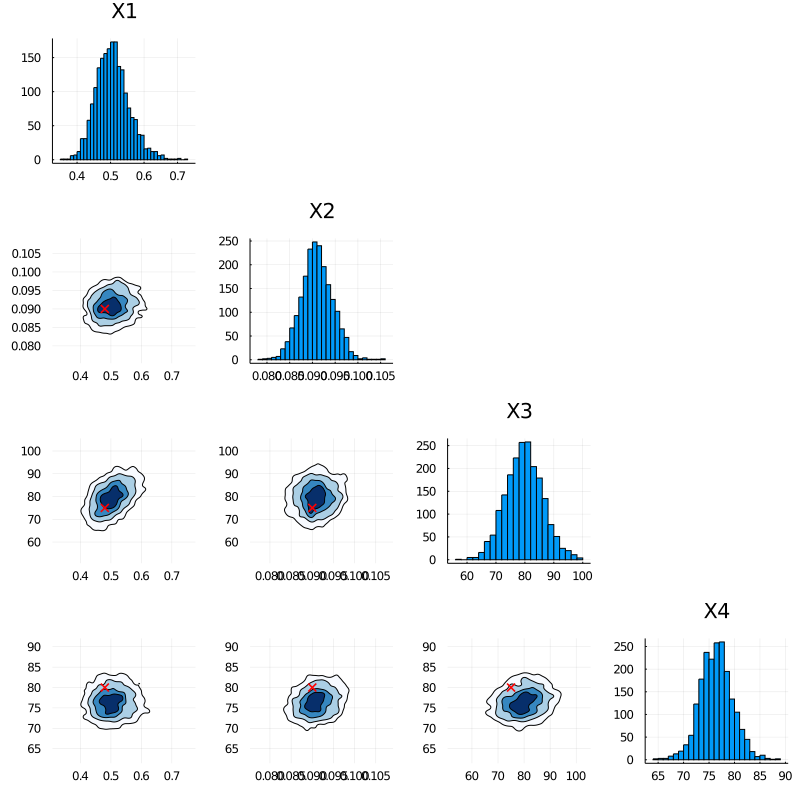

In [10]:
A = hcat(vec(val.α.data),vec(val.β.data),vec(val.γ.data),vec(val.δ.data))
kde_matrix(A,θ₃)

## Model 4 Normal Error

Create the same plot for Model 4, Normal error, compare to dashed intervals in Fig 13

In [11]:
@model function fitm4(data,tspan)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(θ₄[1],5),30,80)
    β ~ truncated(Normal(θ₄[2],50),200,500)
    γ ~ truncated(Normal(θ₄[3],2),1,10)
    δ ~ truncated(Normal(θ₄[4],0.5),0,2)
    
    Y = model4set([α,β,γ,δ],tspan)
    predicted = vec(vcat(Y...))
    for i = 1:length(predicted)
        data[i] ~ Normal(predicted[i], σ)
    end
end
println("MCMC Model 4")
X = vec(vcat(solution4_HD...))
Random.seed!(42) # set seed
ϵ= 0.08./2*mean(X)
Xₙ = X + (ϵ)*randn(eltype(X), size(X))
model = fitm4(Xₙ,tspan_HD) 
chain = sample(model, NUTS(),MCMCThreads(), 1000, 4)
val = get(chain, [:lp,:α,:β,:γ,:δ]);

MCMC Model 4


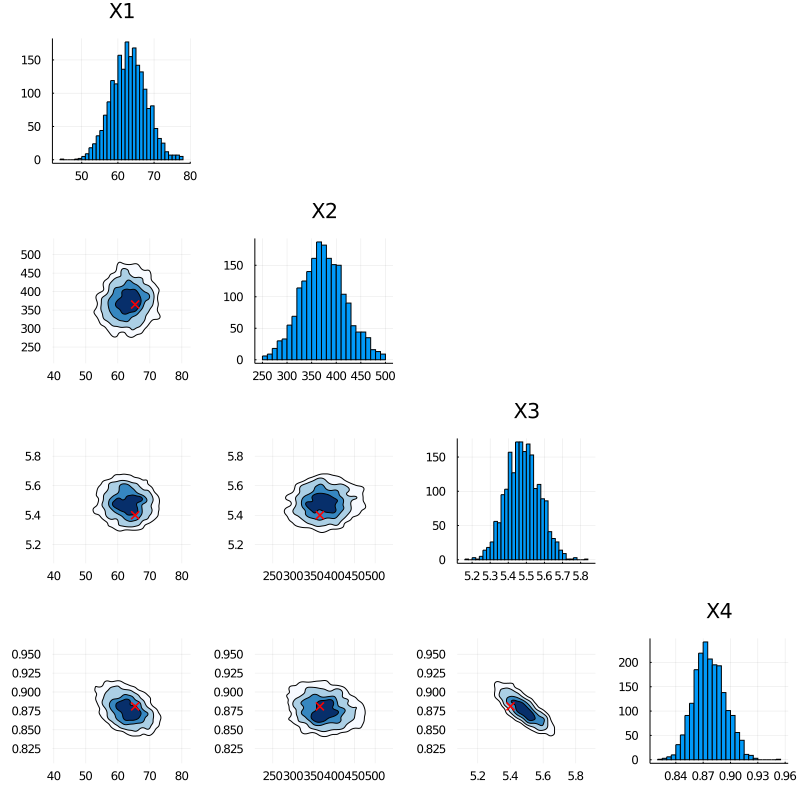

In [12]:
A = hcat(vec(val.α.data),vec(val.β.data),vec(val.γ.data),vec(val.δ.data))
kde_matrix(A,θ₄)

# Next, consider heteroscedastic error

In [13]:
ftir_rf = matread("FTIR_RF.mat")["RF"];
hplc_rf = matread("HPLC_RF.mat")["RF"];

m =(sum((hplc_rf[:,2].-mean(hplc_rf[:,2])).*(hplc_rf[:,1].-mean(hplc_rf[:,1]))))./(sum((hplc_rf[:,2].-mean(hplc_rf[:,2])).^2))# calc slope

hplc_rf .= hplc_rf./[100,100/m]'  # correct magnitudes and slope


# rescale the data for the maximum concentration (220mM)
ftir_rf .*= 0.22/maximum(ftir_rf[:,1])
hplc_rf .*= 0.22/maximum(hplc_rf[:,1])
;

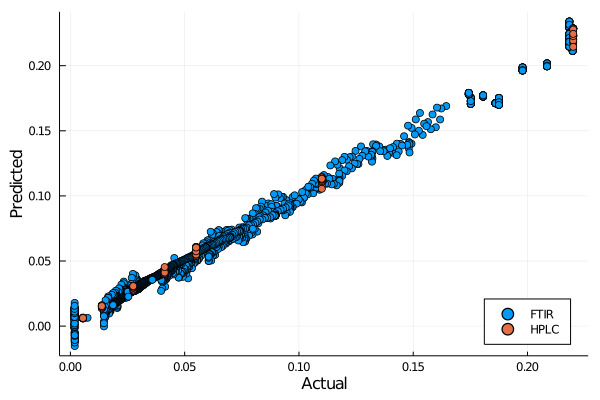

In [14]:
scatter(ftir_rf[:,1],ftir_rf[:,2],label="FTIR",legend=:bottomright)
scatter!(hplc_rf[:,1],hplc_rf[:,2],label="HPLC")
xlabel!("Actual")
ylabel!("Predicted")

The paper used a kernel density smoothed and interpolated lookup implementation of the errors, lets try interpolating from a quantile regression here.  Gaussian process is a possible option, but not explored here.  I wish QR could return a 2D array, here we have to hackily fit a range of quantiles with an x-grid, then interpolate each onto a y-grid.  But a wrinkle: unequally spaced points can only use the nearest neighbor or linear interpolation in Interpolations.jl... for each x location (the ground truth axis), fit the y value (the obervation error) to a skewnormal distribution.Try Quantile Regression, Gaussian process is a possible option, but not explored here.  I wish QR could return a 2D array, here we have to hackily fit a range of quantiles with an x-grid, then interpolate each onto a y-grid with splines to get the gradient - thats the PDF we need.  A warning; I've noticed that the quantiles are not stictly increasing for every data set if the horizon is too short and there are too many quantiles tracked.

In [15]:
using QuantileRegressions, Distributions, Interpolations, DSP
using PyPlot
function estimate_pdf(x,y;smoothing=5,xlen = 99,nq = 9,ylen=99,xg=5)
    X = []
    Y = []
    τ = Array{Float64,1}([])
    yrange =  maximum(y) - minimum(y)
    ygrid = Array(LinRange(minimum(y)-0.5*yrange,maximum(y)+0.5*yrange,ylen))  # fine grid
    for t = range(0.01,0.99,length=nq)
        res = QuantileRegressions.npqreg(Array(y), Array(x), t,IRLS();h=(maximum(x)-minimum(x))/smoothing,m=xlen)
        push!(X,res[1])
        push!(Y,res[2])
        push!(τ,t)
        #p = plot!(res[1], res[2]; label="tau=$t",color="black",alpha=0.5)
    end
    @assert all([XX==X[1] for XX ∈ X]) "Xgrid should be identical for all quantiles "
    xgrid = X[1]
    Ycat = hcat(Y...);
    ycoarse = Array(LinRange(minimum(ygrid),maximum(ygrid),length(τ)*xg)) # coarse equidistiant grid
    pdf_itp = []
    for ix in 1:length(xgrid)
        qs_at_xloc = Ycat[ix,:];
        τ_mat = repeat(τ',size(Ycat,1),1)
        
        #Interpolations.jl wont use splines on uneven spacing so do two step: coarse linear, then spline fits
        itp = interpolate((qs_at_xloc,),logit.(τ),Gridded(Linear()))
        ecdf = extrapolate(itp,Interpolations.Line())
        
        #add second interpolation to get derivatives, splines above linear tended to add wierd curves and negative values
        
        itp2 = interpolate(Array(ecdf(ycoarse)), BSpline(Linear()))
        sitp = Interpolations.scale(itp2, LinRange(extrema(ycoarse)...,length(τ)*xg))
        g = vcat([Interpolations.gradient(sitp, i) for i in ygrid]...)# d(logit(τ))/dy = dτ/dy * 1/(τ-τ²)
        dτ = Array(g).*(logistic.(sitp(ygrid)).-logistic.(sitp(ygrid)).^2)  # solve for dτ/dy = pdf
        
        # the linear interpolation is ragged... smooth dτ with a simple conv kernel
        dτ_smoov = DSP.conv(dτ,[0.05,0.1,0.2,0.3,0.2,0.1,0.05])[4:(3+length(ygrid))]
        
        push!(pdf_itp,dτ_smoov/sum(dτ_smoov))  # collect normalized pdf estimates
        
        
    end
    return hcat(pdf_itp...),xgrid,ygrid,Ycat
end
;

Plot the distribution of FTIR error as a function of concentration, compares to Fig 6b

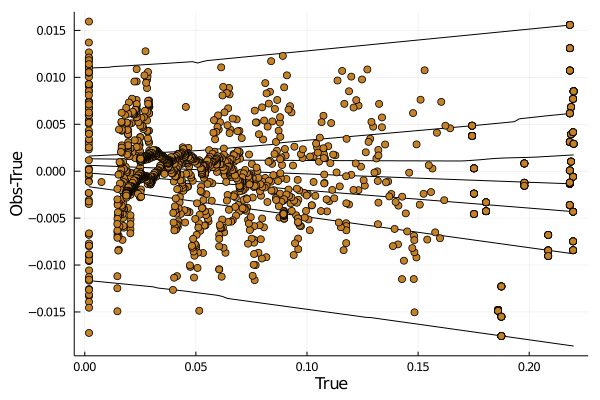

In [16]:
y=ftir_rf[:,2]-ftir_rf[:,1]
x = ftir_rf[:,1]

#p=plot()
pdf_itp_ftir, xgrid_ftir,ygrid_ftir,Ycat = estimate_pdf(x,y,nq=7,smoothing=1,xlen=99,ylen=199)
plot(xgrid_ftir,Ycat;legend = nothing,color="black")
scatter!(x,y)
xlabel!("True")
ylabel!("Obs-True")
#gca(legend = "")


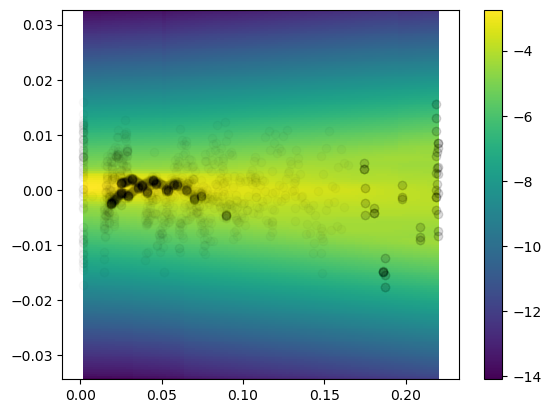

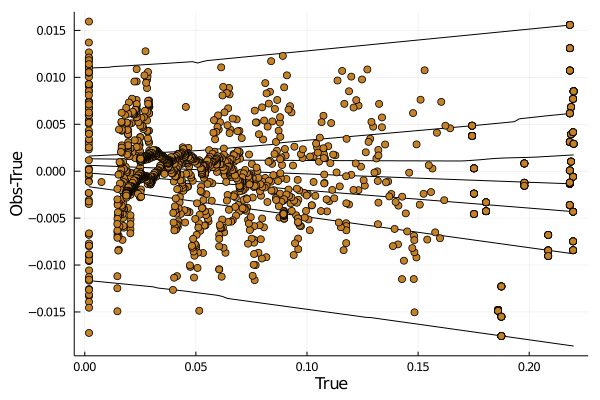

In [17]:

pcolormesh(xgrid_ftir,ygrid_ftir,log.(pdf_itp_ftir.+1e-10))
colorbar()
PyPlot.scatter(x,y,color="black",alpha=0.02)
xlabel!("True")
ylabel!("Obs-True")

Plot the distribution of HPLC error as a function of concentration, compares to Fig 5b

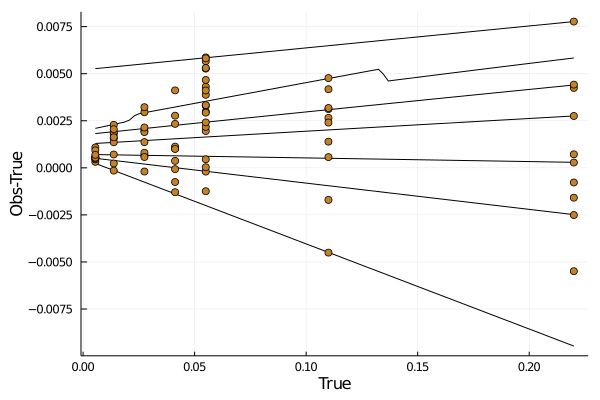

In [18]:

y=hplc_rf[:,2]-hplc_rf[:,1]
x = hplc_rf[:,1]
pdf_itp_hplc, xgrid_hplc,ygrid_hplc,Ycat = estimate_pdf(x,y,smoothing=0.5,nq=7,xlen=99,ylen=199)
plot(xgrid_hplc,Ycat;legend = nothing,color="black")
scatter!(x,y)
xlabel!("True")
ylabel!("Obs-True")


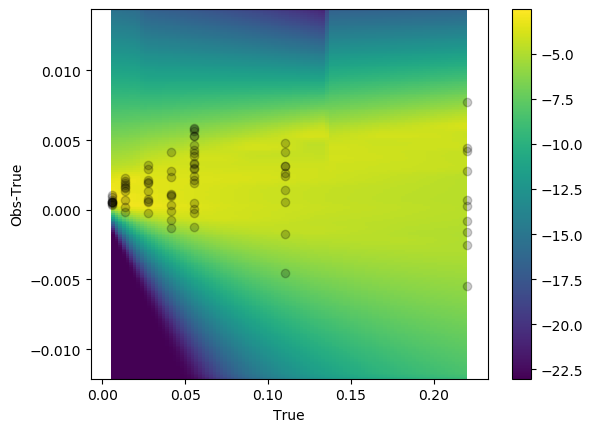

PyObject Text(24.0, 0.5, 'Obs-True')

In [19]:
pcolormesh(xgrid_hplc,ygrid_hplc,log.(pdf_itp_hplc.+1e-10))
colorbar()
PyPlot.scatter(x,y,color="black",alpha=0.2)
PyPlot.xlabel("True")
PyPlot.ylabel("Obs-True")

In [20]:
# create interpolation objects for logpdf:
itp_hplc = LinearInterpolation((ygrid_hplc,xgrid_hplc),log.(pdf_itp_hplc.+1e-10), extrapolation_bc = Line());
rand_hplc(conc) = vcat([sample(ygrid_hplc,ProbabilityWeights(exp.(itp_hplc(ygrid_hplc,c)))) for c in conc]...).+conc;
loglikelihood_HPLC(obs, conc) = sum(itp_hplc.(obs.-conc,conc))


itp_ftir = LinearInterpolation((ygrid_ftir,xgrid_ftir),log.(pdf_itp_ftir.+1e-10), extrapolation_bc = Line());
rand_ftir(conc) = vcat([sample(ygrid_ftir,ProbabilityWeights(exp.(itp_ftir(ygrid_ftir,c)))) for c in conc]...).+conc;
loglikelihood_FTIR(obs, conc) = sum(itp_ftir.(obs.-conc,conc))
;

Ok, we have some idea of the conditional error distributions, and a hacky way to calculate them.  Now include them in Turing with the `addlogprob!` macro.

## Model 1, FTIR based error
Compare to Fig 10c

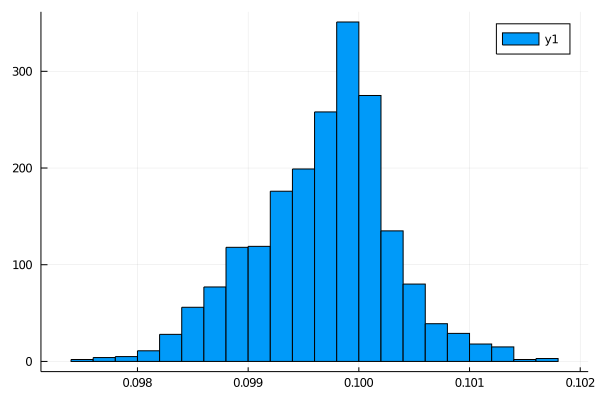

In [21]:
# try MCMC inference for hetero error

@model function fitm1(data,tspan,llfun)    
    α ~ truncated(Normal(0.2,1),1e-5,1)
    predicted = model1(1 ./C₀₁,α,tspan) # returns mM⁻¹
    if !isa(_context, Turing.PriorContext)
        Turing.@addlogprob! llfun(data, 1.0./predicted)
    end
    
end
X = 1 ./solution1_HD # invert to mM

Random.seed!(42) # set seed
Xₙ = rand_ftir(X)#add error (mM)
model = fitm1(Xₙ,tspan_HD,loglikelihood_FTIR) # 
chain = sample(model, NUTS(),MCMCThreads(), 1000, 4)
val = get(chain, [:lp,:α])
histogram(vec(val.α))

## Model 2, FTIR based error
Compare to Fig 11c

MCMC Model 2


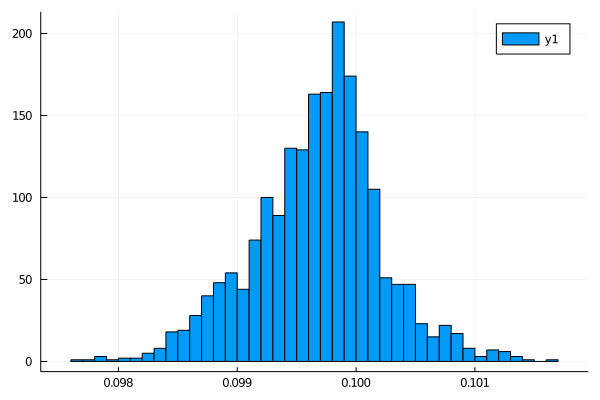

In [22]:
@model function fitm2(data,tspan,llfun)
    α ~ truncated(Normal(0.2,1.0),1e-5,2)
    prob = ODEProblem(model2, C₀₂, (0.0,maximum(tspan)), [α])
    solution2 = solve(prob,Tsit5(), saveat = tspan,verbose = false,save_idxs= [1], save_everystep = false)
    predicted =vcat(solution2.u...)
    if !isa(_context, Turing.PriorContext)
        Turing.@addlogprob! llfun(data, predicted)
    end
end
println("MCMC Model 2")
X = vcat(solution2_HD.u...)
Random.seed!(42) # set seed
Xₙ = rand_ftir(X)#add error
model = fitm2(Xₙ,tspan_HD,loglikelihood_FTIR) 
chain = sample(model, NUTS(),MCMCThreads(), 1000, 4)
val = get(chain, [:lp,:α])
histogram(vec(val.α))

## Model 3, HPLC based error
Compare to Fig 12 gray contours


In [23]:

@model function fitm3(data,tspan,llfun)
    α ~ truncated(Normal(0.2,1.0),1e-5,1)
    β ~ truncated(Normal(0.2,1.0),1e-5,1)
    γ ~ truncated(Normal(80,10),40,100)
    δ ~ truncated(Normal(80,10),40,100)

    Y = model3set([α,β,γ,δ],tspan)
    predicted = vec(vcat(Y...))
    if !isa(_context, Turing.PriorContext)
        Turing.@addlogprob! llfun(data, predicted)
    end
end
println("MCMC Model 3")
X = vec(vcat(solution3_SD...))
Random.seed!(43) # set seed
Xₙ = rand_hplc(X)
model = fitm3(vec(Xₙ),tspan_SD,loglikelihood_HPLC) 
chain = sample(model, NUTS(),MCMCThreads(), 1000, 4)
val = get(chain, [:lp,:α,:β,:γ,:δ]);

MCMC Model 3


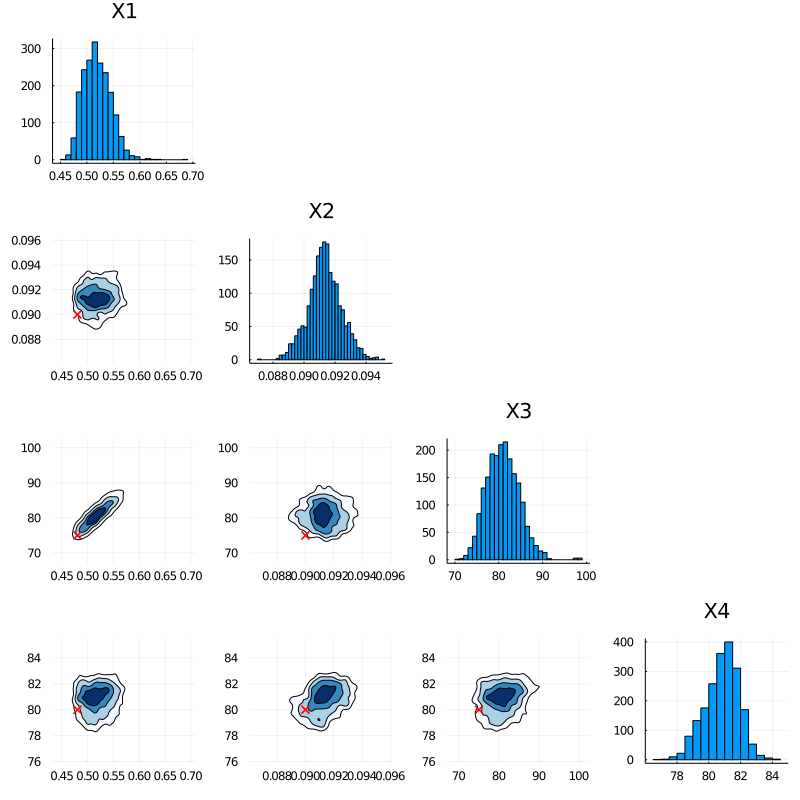

In [24]:
A = hcat(vec(val.α.data),vec(val.β.data),vec(val.γ.data),vec(val.δ.data))
kde_matrix(A,θ₃)

## Model 4, FITR based error
Compare to Fig 13, gray contours

In [25]:
@model function fitm4(data,tspan,llfun)
    α ~ truncated(Normal(θ₄[1],5),30,80)
    β ~ truncated(Normal(θ₄[2],50),200,500)
    γ ~ truncated(Normal(θ₄[3],2),1,10)
    δ ~ truncated(Normal(θ₄[4],0.5),0,2)
    
    Y = model4set([α,β,γ,δ],tspan)
    predicted = vec(vcat(Y...))
    if !isa(_context, Turing.PriorContext)
        Turing.@addlogprob! llfun(data, predicted)
    end
end
println("MCMC Model 4")
X = vec(vcat(solution4_HD...))
Random.seed!(42) # set seed
Xₙ = rand_ftir(X)
model = fitm4(vec(Xₙ),tspan_HD,loglikelihood_FTIR) 
chain = sample(model, NUTS(),MCMCThreads(), 1000, 4)
val = get(chain, [:lp,:α,:β,:γ,:δ]);


MCMC Model 4


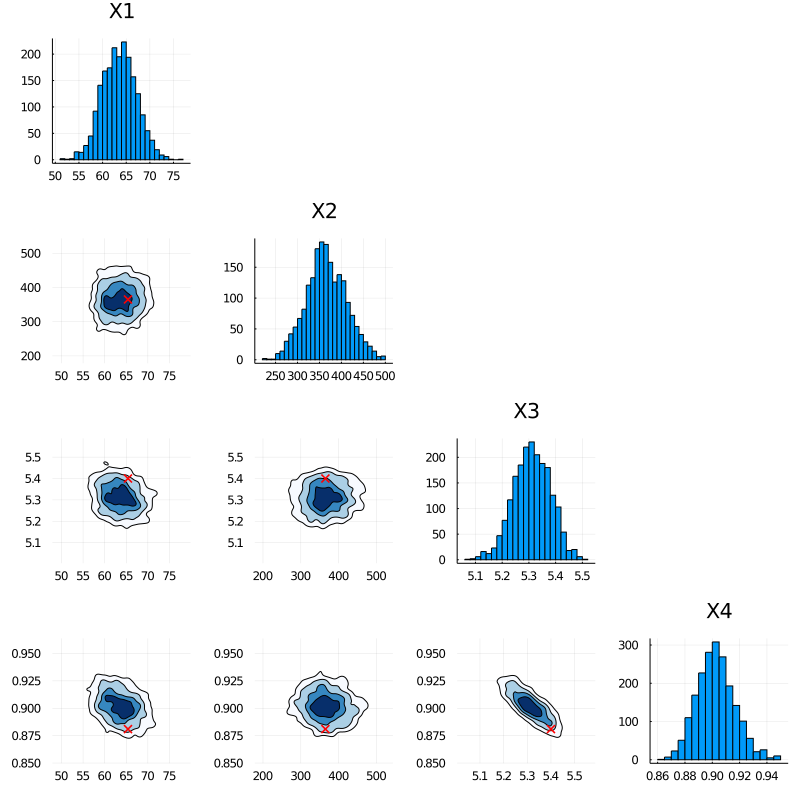

In [26]:
A = hcat(vec(val.α.data),vec(val.β.data),vec(val.γ.data),vec(val.δ.data))
kde_matrix(A,θ₄)

# Conclusion
`Turing.jl` and `DifferentialEquations.jl` are pretty awesome to work with to solve ODEs using Bayesian inference.  I know it is to be expected for any simulation study done years ago, but the computational performance with the recent algorithmic improvements is orders of magitude better (minutes, not hours! even for the unoptimized models here) than in the previous work.  What a difference a few years makes, I'm looking forward to what the future brings!

# Appendix: Pkg.status()

In [27]:
versioninfo()

Julia Version 1.5.2
Commit 539f3ce943 (2020-09-23 23:17 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i3-4130 CPU @ 3.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, haswell)
Environment:
  JULIA_CMDSTAN_HOME = /home/jak/cmdstan-2.24.1
  JULIA_NUM_THREADS = 4


In [28]:
]status

Status `~/Dropbox/julia/universal_differential_equations/ChemicalKinetics/Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [336ed68f] CSV v0.8.2
  [479239e8] Catalyst v5.1.0
  [717857b8] DSP v0.6.10
  [2445eb08] DataDrivenDiffEq v0.4.1 `https://github.com/SciML/DataDrivenDiffEq.jl#master`
  [a93c6f00] DataFrames v0.21.8
  [2b5f629d] DiffEqBase v6.48.2
  [ebbdde9d] DiffEqBayes v2.17.0
  [aae7a2af] DiffEqFlux v1.24.0
  [41bf760c] DiffEqSensitivity v6.33.0
  [0c46a032] DifferentialEquations v6.15.0
  [31c24e10] Distributions v0.23.12
  [6a86dc24] FiniteDiff v2.7.2
  [26cc04aa] FiniteDifferences v0.10.9
  [587475ba] Flux v0.11.1
  [f6369f11] ForwardDiff v0.10.14
  [7073ff75] IJulia v1.23.0
  [a98d9a8b] Interpolations v0.12.10
  [5ab0869b] KernelDensity v0.6.2
  [23992714] MAT v0.8.1
  [429524aa] Optim v1.2.0
  [1dea7af3] OrdinaryDiffEq v5.44.0
  [91a5bcdd] Plots v1.7.3
  [d330b81b] PyPlot v2.9.0
  [c6596682] QuantileRegressions v0.1.6
  [276daf66] SpecialFunctions v0.10.3
  [90137ffa] St